# Initial Setup

## Libraries

In [1]:
%%capture
!pip install soundfile
#!pip install tf-nightly

In [2]:
import warnings
import sys
warnings.filterwarnings('ignore')

import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)
 
import numpy as np
import scipy
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook
import soundfile as sf
 
import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Activation, Conv1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow.keras.backend as kb

In [4]:
print("=== Library Versions ===")
print("SciPy:     ",scipy.__version__)
print("Numpy:     ",np.__version__)
print("TensorFlow:",tf.__version__)
print("Keras:     ",keras.__version__)
print("Soundfile: ",sf.__version__)

=== Library Versions ===
SciPy:      1.4.1
Numpy:      1.18.5
TensorFlow: 2.3.0
Keras:      2.4.0
Soundfile:  0.10.3


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Custom Functions

In [ ]:
# Convolute two audio signals
def conv(source, impulse):
  split = source.split('.')
  conv_output = '.'.join(split[:-1])+'_conv.' + split[-1]
 
  clip_factor = 1.01 # clip factor default value
 
  h1, Fs1 = sf.read( impulse ) # impulse response
  x1, Fs2 = sf.read( source ) # file to process
 
  if Fs1 == Fs2 : # if sample rates are the same
    print("Processing...")
    y1 = signal.fftconvolve(x1,h1).real # takes the real part to avoid a too small complex part (around e-18)
 
    # audio normalization: if "y = y/max(y)" -> "values out of [-1,+1] range are clipped"
    y1 = y1/( max(y1)*clip_factor ) # to avoid clipping
    
    sf.write( conv_output, y1, Fs1 )
 
    print("Output file:", conv_output)
    print("Convolution success.")
 
    return conv_output
  else:
    print("Error: files has different sample rate.")

In [ ]:
# Function: Convert some hex value into an array for C programming
# Source: Machine Learning on Microcontroller Lecture, ETH Zurich
def hex_to_c_array(hex_data, var_name):
 
    c_str = ''
 
    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'
 
    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'
 
    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :
 
        # Construct string from hex
        hex_str = format(val, '#04x')
 
        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)
 
    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'
 
    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'
 
    return c_str

In [ ]:
# Error-to-Signal Ratio
def ESR(y_actual,y_predicted):
    return kb.sum(kb.square(y_actual-y_predicted),axis=0)/(kb.sum(kb.square(y_actual),axis=0)+kb.epsilon())

In [ ]:
class AudioSequence(Sequence):
  def __init__(self, x_set, y_set, batch_size, rec_field, shuffle=False):
    self.x, self.y = x_set, y_set
    self.rec_field = rec_field
    self.batch_size = batch_size
    self.shuffle = shuffle
 
     # Matrix, each column containing the previous N input samples
    self.batch_x = np.empty((self.batch_size ,self.rec_field,1))
    # Vector, each entry containing the current output samples
    self.batch_y = np.empty((self.batch_size ,1,1))
 
    self.order = np.arange(0, self.__len__())
 
    if self.shuffle:
      self.order = np.random.randint(0,self.__len__(),self.__len__())
 
  def __len__(self):
    return np.math.floor((len(self.x)-self.rec_field) / self.batch_size)
 
  def __getitem__(self, idx, ):
    batch = self.order[idx]*self.batch_size
   
    self.batch_x[:,:,0] = np.lib.stride_tricks.as_strided(
        self.x[batch:batch+self.rec_field+self.batch_size],
        (self.batch_size, self.rec_field), 
        (8, 8),
        writeable=False
    )
    self.batch_y[:,0,0] = self.y[batch+self.rec_field:batch+self.rec_field+self.batch_size]
 
    return np.array(self.batch_x), np.array(self.batch_y)
 
  def on_epoch_end(self):
    if self.shuffle:
      self.order = np.random.randint(0,self.__len__(),self.__len__())

In [ ]:
def generate_dataset(audio_input, audio_amp, rec_field, samples=-1):
    if samples == -1 or samples < 0:
      samples = len(audio_input)-rec_field

    # Matrix, each column containing the previous N input samples
    X = np.empty((samples ,rec_field,1))
    # Vector, each entry containing the current output samples
    y = np.empty((samples ,1,1))
   
    X[:,:,0] = np.lib.stride_tricks.as_strided(
        audio_input,
        (samples, rec_field), 
        (8, 8),
        writeable=False
    )
    y[:,0,0] = audio_amp[rec_field:rec_field+samples]

    return X, y

# Configuration

In [ ]:
DEBUG = False
TRAIN = True

# Neural Network
CHANNELS    = 4
KERNEL_SIZE = 3
EPOCHS      = 10
BATCH_SIZE  = 256
BATCH_SIZE_PREDICT = 1024

QUANTIZE = True
 
HOME_FOLDER = '/content/drive/MyDrive/Colab Notebooks/'
 
# Model Description
ITERATION = 3
VERSION = 1
NAME = 'OrangeMicroDark'
IDENTIFIER = 'WN12'
 
# Data
TEST_DURATION = 10    # seconds
SHUFFLE       = True
 
TRAIN_TEST_SPLIT = 0.85 # Use 60% for training
TRAIN_VAL_SPLIT  = 0.9 # Use another 60% of the remaining data for training and 30% for validation
 
TRAIN_AUDIO_IN  = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_in.wav'
TRAIN_AUDIO_AMP = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_disto.wav'
TRAIN_AUDIO_AMP_CONV = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_disto_conv.wav'
IMPULSE_AUDIO  = HOME_FOLDER + 'Datasets/GuitarCabinetIR.wav'
 
# Models
WN10 = [1,2,4,8,16,32,64,128,256,512]
WN12 = [1,2,4,8,16,32,1,2,4,8,16,32]
WN18 = [1,2,4,8,16,32,64,128,256,1,2,4,8,16,32,64,128,256]
WN24 = [1,2,4,8,16,32,64,128,1,2,4,8,16,32,64,128,1,2,4,8,16,32,64,128]
 
print('=== Receptive Fields ===')
N = (KERNEL_SIZE-1)*np.sum(WN10)+1
print("WN{}: {:4d} samples".format(len(WN10), N))
 
N = (KERNEL_SIZE-1)*np.sum(WN12)+1
print("WN{}: {:4d} samples".format(len(WN12), N))
 
N = (KERNEL_SIZE-1)*np.sum(WN18)+1
print("WN{}: {:4d} samples".format(len(WN18), N))
 
N = (KERNEL_SIZE-1)*np.sum(WN24)+1
print("WN{}: {:4d} samples".format(len(WN24), N))

In [ ]:
if IDENTIFIER == 'WN10':
  DILATATION_RATES = WN10
elif IDENTIFIER == 'WN12':
  DILATATION_RATES = WN12
elif IDENTIFIER == 'WN18':
  DILATATION_RATES = WN18
elif IDENTIFIER == 'WN24':
  DILATATION_RATES = WN24
else:
  print("ERROR!")

REC_FIELD = (KERNEL_SIZE-1)*np.sum(DILATATION_RATES)+1

print("Using Mode:     ", IDENTIFIER)
print("Receptive Field:", REC_FIELD)

In [ ]:
MODEL_NAME = '{:02d}_{}_{}_v{:d}'.format(ITERATION,NAME,IDENTIFIER,VERSION) 
MODEL_PATH = '{}{:02d}_Data/{}'.format(HOME_FOLDER, ITERATION,MODEL_NAME) 
 
print("=== File Configuration ===")
print("Model Name :", MODEL_NAME)
print("Audio Input:", TRAIN_AUDIO_IN)
print("Audio Amp  :", TRAIN_AUDIO_AMP)
print("Impulse R. :", IMPULSE_AUDIO)
print("Model Path :", MODEL_PATH)

# Preprocessing

## Import Audio

In [ ]:
if DEBUG: 
  ipd.Audio(TRAIN_AUDIO_IN)

In [ ]:
if DEBUG: 
  ipd.Audio(TRAIN_AUDIO_AMP)

In [ ]:
# Import audio data
srate, audio_input = wavfile.read(TRAIN_AUDIO_IN)
_, audio_amp       = wavfile.read(TRAIN_AUDIO_AMP)

print('Total number of input samples: ' + str(np.size(audio_input)))
print('Total number of output samples: ' + str(np.size(audio_amp)))

## Build Dataset

In [ ]:
# Convert to numpy array and re-scale 16-bit wave file to [-1,1]
audio_input = np.array(audio_input)/2**15
audio_amp   = np.array(audio_amp)/2**15

In [ ]:
index_test  = int(np.size(audio_input)*(1-TRAIN_TEST_SPLIT))
index_val   = int(np.size(audio_input)*(1-TRAIN_VAL_SPLIT)*TRAIN_TEST_SPLIT)+index_test
index_train = int(np.size(audio_input)*TRAIN_VAL_SPLIT*TRAIN_TEST_SPLIT)+index_test
 
test_audio_input  = audio_input[0:index_test-REC_FIELD]
val_audio_input   = audio_input[index_test:index_val-REC_FIELD]
train_audio_input = audio_input[index_val:]
 
test_audio_amp    = audio_amp[0:index_test-REC_FIELD]
val_audio_amp     = audio_amp[index_test:index_val-REC_FIELD]
train_audio_amp   = audio_amp[index_val:]
 
print("Test Size  : {:7d} samples, {:.2f} s".format(test_audio_input.shape[0], test_audio_input.shape[0]/srate))
print("Val Size   : {:7d} samples, {:.2f} s".format(val_audio_input.shape[0], val_audio_input.shape[0]/srate))
print("Train Size : {:7d} samples, {:.2f} s".format(train_audio_input.shape[0], train_audio_input.shape[0]/srate))
print()
print("Test Size  : {:7d} samples, {:.2f} s".format(test_audio_amp.shape[0], test_audio_amp.shape[0]/srate))
print("Val Size   : {:7d} samples, {:.2f} s".format(val_audio_amp.shape[0], val_audio_amp.shape[0]/srate))
print("Train Size : {:7d} samples, {:.2f} s".format(train_audio_amp.shape[0], train_audio_amp.shape[0]/srate))
 
test_audio_input_padded = np.pad(test_audio_input, (REC_FIELD,0) )
test_audio_amp_padded   = np.pad(test_audio_amp, (REC_FIELD,0) )
 
seq_test  = AudioSequence(test_audio_input_padded,  test_audio_amp_padded,  BATCH_SIZE_PREDICT, REC_FIELD)
seq_train = AudioSequence(train_audio_input, train_audio_amp, BATCH_SIZE, REC_FIELD, shuffle=SHUFFLE)
seq_val   = AudioSequence(val_audio_input,   val_audio_amp,   BATCH_SIZE_PREDICT, REC_FIELD, shuffle=SHUFFLE)

In [ ]:
if DEBUG: 
  d = generate_dataset(train_audio_input, train_audio_amp, REC_FIELD, BATCH_SIZE_PREDICT)
  print(d[0].shape,d[1].shape)
  
  plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD),train_audio_amp[REC_FIELD:REC_FIELD+BATCH_SIZE_PREDICT], 'b-', linewidth=2, alpha=0.6)
  plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), d[1].reshape(-1), 'r--')
  plt.title("AMP Output")
  #plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
  plt.show()
  
  plt.plot(train_audio_input[:BATCH_SIZE_PREDICT+REC_FIELD], 'b-', linewidth=2, alpha=0.6)
  plt.plot(np.arange(0, BATCH_SIZE_PREDICT), d[0][:,0].reshape(-1), 'r--')
  plt.plot(np.arange(BATCH_SIZE_PREDICT, REC_FIELD+BATCH_SIZE_PREDICT), d[0][-1,:].reshape(-1), 'r--')
  plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
  plt.title("AMP Input")
  plt.show()

In [ ]:
if DEBUG: 
  INDEX = 10
  plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD),test_audio_amp_padded[INDEX*BATCH_SIZE_PREDICT+REC_FIELD:REC_FIELD+(1+INDEX)*BATCH_SIZE_PREDICT], 'b-', linewidth=2, alpha=0.6)
  plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), seq_test.__getitem__(INDEX)[1].reshape(-1), 'r--')
  plt.title("AMP Output")
  #plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
  plt.show()
  
  plt.plot(test_audio_input_padded[INDEX*BATCH_SIZE_PREDICT:(1+INDEX)*BATCH_SIZE_PREDICT+REC_FIELD], 'b-', linewidth=2, alpha=0.6)
  plt.plot(np.arange(0, BATCH_SIZE_PREDICT), seq_test.__getitem__(INDEX)[0][:,0].reshape(-1), 'r--')
  plt.plot(np.arange(BATCH_SIZE_PREDICT, REC_FIELD+BATCH_SIZE_PREDICT), seq_test.__getitem__(INDEX)[0][-1,:].reshape(-1), 'r--')
  plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
  plt.title("AMP Input")
  plt.show()

In [ ]:
ipd.Audio(data=test_audio_input_padded,rate=srate)

In [ ]:
ipd.Audio(data=test_audio_amp_padded,rate=srate)

# Neural Network

## Definition

In [ ]:
# Creating the model from the paper
model = Sequential( name = MODEL_NAME)
 
model.add(Input(shape = (REC_FIELD,1)))
 
for i in DILATATION_RATES:
  model.add(Conv1D(CHANNELS, KERNEL_SIZE, dilation_rate=i,activation='tanh'))
 
 
model.layers[-1].filters = 1
model = model_from_json(model.to_json())

In [ ]:
# Display a summary of the model (number of layers and parameters, ect)
model.summary()

Model: "03_OrangeMicroDark_WN12_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 251, 4)            16        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 247, 4)            52        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 239, 4)            52        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 223, 4)            52        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 191, 4)            52        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 127, 4)            52        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 125,

In [ ]:
if TRAIN:
  # Compile model (define optimization algorithm, loss function)
  model.compile(optimizer=Adam(learning_rate=0.001),loss=ESR)

## Training

In [ ]:
if TRAIN:
  # Train the network
  history = model.fit(seq_train, validation_data=seq_val, epochs = EPOCHS, max_queue_size=200)

Epoch 1/10
9168/9168 [==============================] - 1035s 113ms/step - loss: 0.4501 - val_loss: 0.1647
Epoch 2/10
9168/9168 [==============================] - 996s 109ms/step - loss: 0.1642 - val_loss: 0.1512
Epoch 3/10
9168/9168 [==============================] - 987s 108ms/step - loss: 0.1663 - val_loss: 0.1340
Epoch 4/10
9168/9168 [==============================] - 1003s 109ms/step - loss: 0.1943 - val_loss: 0.1219
Epoch 5/10
9168/9168 [==============================] - 980s 107ms/step - loss: 0.8028 - val_loss: 0.1152
Epoch 6/10
9168/9168 [==============================] - 978s 107ms/step - loss: 0.1187 - val_loss: 0.1628
Epoch 7/10
9168/9168 [==============================] - 998s 109ms/step - loss: 0.0951 - val_loss: 0.1349
Epoch 8/10
9168/9168 [==============================] - 1021s 111ms/step - loss: 0.0876 - val_loss: 0.0981
Epoch 9/10
9168/9168 [==============================] - 1022s 112ms/step - loss: 0.0880 - val_loss: 0.0995
Epoch 10/10
9168/9168 [===================

In [ ]:
if TRAIN:
  # Save the model
  model.save(MODEL_PATH + '.h5') 

## Evaluation

dict_keys(['loss', 'val_loss'])


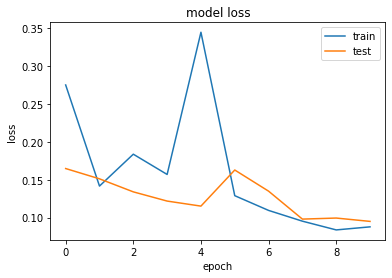

In [ ]:
if TRAIN:
  # list all data in history
  print(history.history.keys())
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

In [ ]:
LOAD_MODEL = MODEL_PATH
 
model = tf.keras.models.load_model(LOAD_MODEL + '.h5', custom_objects={'ESR': ESR})
print("Loading Model:", LOAD_MODEL + '.h5')

Loading Model: /content/drive/MyDrive/Colab Notebooks/03_Data/03_OrangeMicroDark_WN12_v1.h5


In [ ]:
print("Evaluate on test data")
results = model.evaluate(seq_test, workers=1, max_queue_size=20, steps=np.floor(TEST_DURATION*srate/BATCH_SIZE_PREDICT), verbose=1)
print("Test ESR: {:.2f}%".format(100*results))

Evaluate on test data
430/430 [==============================] - 82s 190ms/step - loss: 0.1080
Test ESR: 10.80%


In [ ]:
print("Generate Output")
audio_pred = model.predict(seq_test, workers=1, max_queue_size=20, steps=np.ceil(TEST_DURATION*srate/BATCH_SIZE_PREDICT), verbose=1)
wavfile.write(LOAD_MODEL + '.wav', srate, audio_pred[:,0,0])

# Convolute signal with impulse response from loudspeaker
pred_model_path = conv(LOAD_MODEL + '.wav', IMPULSE_AUDIO)

Generate Output
431/431 [==============================] - 82s 189ms/step
Processing...
Output file: /content/drive/MyDrive/Colab Notebooks/03_Data/03_OrangeMicroDark_WN12_v1_conv.wav
Convolution success.


# Post Training Quantization

## Conversion

In [ ]:
QUANTIZE = False

LOAD_MODEL = MODEL_PATH

model = tf.keras.models.load_model(LOAD_MODEL + '.h5', custom_objects={'ESR': ESR})
print("Loading Model:", LOAD_MODEL + '.h5')
if QUANTIZE:
  LOAD_TFL = LOAD_MODEL + '_tfl_int8'
  #LOAD_TFL = LOAD_MODEL + '_tfl_float16'
else:
  LOAD_TFL = LOAD_MODEL + '_tfl'

Loading Model: /content/drive/MyDrive/Colab Notebooks/03_Data/03_OrangeMicroDark_WN12_v1.h5


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model( model)
converter.experimental_new_converter=False

# Convert the model to the TensorFlow Lite format with quantization
if (QUANTIZE):    
  def representative_dataset():
    dataset = generate_dataset(val_audio_input, val_audio_amp, REC_FIELD)[0]
    for i in tqdm_notebook(range(len(val_audio_input)-REC_FIELD)):
      yield([dataset[i].astype(np.float32).reshape(1,REC_FIELD,1)]) 
 
  # Set the optimization flag.
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # Enforce full-int8 quantization
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    #tf.lite.OpsSet.TFLITE_BUILTINS,
  ]
 
  #converter.target_spec.supported_types = [tf.float16]
  #converter.target_spec.supported_types = [tf.int8]
 
  #converter.inference_input_type = tf.int8  # or tf.uint8
  #converter.inference_output_type = tf.int8  # or tf.uint8
 
  # Provide a representative dataset to ensure we quantize correctly.
  converter.representative_dataset = representative_dataset
  
tflite_model = converter.convert()

print("Save TFLite:", LOAD_TFL + '.tflite')
open(LOAD_TFL + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpitqyo5y4/assets


Save TFLite: /content/drive/MyDrive/Colab Notebooks/03_Data/03_OrangeMicroDark_WN12_v1_tfl.tflite


10376

In [ ]:
# Write TFLite model to a C source (or header) file
with open(LOAD_TFL + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, MODEL_NAME))

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=LOAD_TFL + '.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()
 
print("== Input details ==")
print("name :", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type :", input_details[0]['dtype'])
 
print("\n== Output details ==")
print("name :", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type :", output_details[0]['dtype'])

== Input details ==
name : input_1
shape: [  1 253   1]
type : <class 'numpy.float32'>

== Output details ==
name : Identity
shape: [  1 249   1]
type : <class 'numpy.float32'>


## Evaluation

In [ ]:
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

X,y  = generate_dataset(test_audio_amp_padded, test_audio_amp_padded, REC_FIELD)
if (input_scale == 0):
  input_scale = 1.0
if (output_scale == 0):
  output_scale = 1.0

X = X / input_scale + input_zero_point
y = y / output_scale + output_zero_point

print("Input Scale :", input_scale)
print("Input Zero  :", input_zero_point)
print("Output Scale:", output_scale)
print("Output Zero :", output_zero_point)

Input Scale : 1.0
Input Zero  : 0
Output Scale: 1.0
Output Zero : 0


In [ ]:
output = np.zeros(len(test_audio_input_padded)-REC_FIELD, dtype=output_details[0]['dtype'])

for i in tqdm_notebook(range((len(test_audio_amp_padded)-REC_FIELD))):
    #We must convert the data into int8 format before invoking inference.
    val_batch = X[i]
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()
    output[i] = tflite_interpreter.get_tensor(output_details[0]['index'])

wavfile.write(LOAD_TFL + '.wav', srate, (output-output_zero_point)*output_scale)
# Convolute signal with impulse response from loudspeaker
pred_tflite_path = conv(LOAD_TFL + '.wav', IMPULSE_AUDIO)

ValueError: ignored

In [ ]:
print("Original")
ipd.Audio(test_audio_amp_padded, rate=srate)

In [ ]:
print("TensorFlow Model")
ipd.Audio(LOAD_MODEL + '.wav')

In [ ]:
print("TensorFlow Lite Model")
ipd.Audio(output, rate=srate)

In [ ]:
print("Original (Convoluted)")
ipd.Audio(TRAIN_AUDIO_AMP_CONV)

In [ ]:
print("TensorFlow Model (Convoluted)")
ipd.Audio(pred_model_path)

In [ ]:
print("TensorFlow Lite Model (Convoluted)")
ipd.Audio(pred_tflite_path)

In [ ]:
error = ESR(test_audio_amp_padded[REC_FIELD:REC_FIELD+44100],  [:44100])
print("Test ESR: {:.2f}%".format(100*error))